# Tarea uso de pipelines para sintonizar modelos regularizados

1. Cargue el archivo **student-mat.csv**. La información de las variables la encuentra en el archivo **student.txt**.

Implemente un modelo Ridge que prediga la variable **G3** a partir de las otras variables. Debe:
- Sintonizar $\lambda$ por validación cruzada usando como métrica RMSE.
- Codifcar las variables nominales y ordinales, y estandarizar las variables numéricas, todas dentro de un *pipeline*.
- Particionar los datos en subconjunto de entrenamiento y prueba en una proporción 70/30, fijando **random_state=1**.

Reporte:
- El error de validación obtenido y el $\lambda$ correspondiente.
- El error de prueba.
- Los coeficientes asociados a cada característica del modelo, incluyendo el intercepto.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df= pd.read_csv('student-mat.csv',sep=r';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

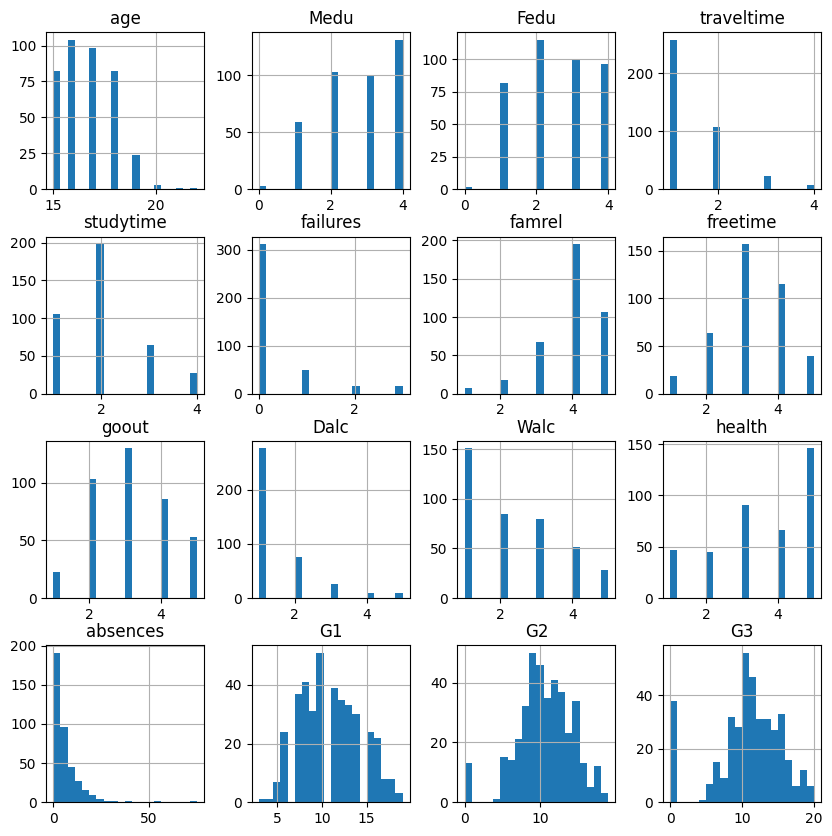

In [ ]:
df.select_dtypes('number').hist(bins=20, figsize=(10,10));

In [14]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [5]:
X = df.drop(columns=['G3'])
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.7)
print(f'Tamaño del conjunto de entrenamiento es: {X_train.shape}')
print(f'Tamaño del conjunto de prueba es: {X_test.shape}')


Tamaño del conjunto de entrenamiento es: (276, 32)
Tamaño del conjunto de prueba es: (119, 32)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

In [ ]:

ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
ordinal_categories = [
    [0, 1, 2, 3, 4],
    [0, 1, 2, 3, 4],
    [1, 2, 3, 4],
    [1, 2, 3, 4],
    [0, 1, 2, 3, 4],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
]
nominal_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
                    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
numerical_features = ['age', 'absences', 'G1', 'G2']

ordinal_transformer = OrdinalEncoder(categories=ordinal_categories)
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ordinal_features),
        ('nominal', nominal_transformer, nominal_features),
        ('numerical', numerical_transformer, numerical_features)
    ]
)


In [12]:

pipe = Pipeline([('preprocessor',preprocessor),('model',Ridge())]) # Se define un pipeline con el preprocesador y el modelo Ridge
alpha = np.logspace(-4,2)
grid = {'model__alpha':alpha}
grid_search = GridSearchCV(estimator=pipe, # Se define el modelo a sintonizar, que incluye el preprocesador y el modelo Ridge
                           param_grid=grid, # Se define la grilla de hiperparámetros que se va a sintonizar
                           cv=5, # Se define el número de folds en la validación cruzada
                           scoring='neg_root_mean_squared_error') # Se define la métrica de evaluación, en este caso RMSE
grid_search.fit(X_train, y_train)

print(f'Mejor RMSE obtenido fue {-grid_search.best_score_:.3} con hiperparámetros de {grid_search.best_params_}.')
print(f'Error de prueba: {root_mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)):.3f}')

Mejor RMSE obtenido fue 2.12 con hiperparámetros de {'model__alpha': 18.420699693267164}.
Error de prueba: 1.910


In [13]:
pesos = pd.DataFrame(data=grid_search.best_estimator_.named_steps['model'].coef_, # Se extraen los coeficientes del modelo Ridge
                     index=grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out().tolist(), # Se extraen los nombres de las variables
                     columns=['Coeficiente'])
pesos.loc['intercepto'] = grid_search.best_estimator_.named_steps['model'].intercept_ # Se extrae el intercepto del modelo Ridge
pesos

,Coeficiente
ordinal__Medu,0.229717
ordinal__Fedu,-0.032466
ordinal__traveltime,-0.037283
ordinal__studytime,-0.030468
ordinal__failures,-0.147046
ordinal__famrel,0.232433
ordinal__freetime,0.085374
ordinal__goout,0.074424
ordinal__Dalc,-0.129499
ordinal__Walc,0.122938


2. Ahora, implemente un modelo Ridge que prediga la variable **G3**, pero previamente haga selección de características mediante un modelo Lasso, de manera que le queden entre 10 y 15 características.

Debe:
- Sintonizar $\lambda$ por validación cruzada usando como métrica RMSE.
- Codifcar las variables nominales y ordinales, y estandarizar las variables numéricas, todas dentro de un *pipeline*.
- Particionar los datos en subconjunto de entrenamiento y prueba en una proporción 70/30, fijando **random_state=1**.

Reporte:
- El error de validación obtenido y el $\lambda$ correspondiente.
- El error de prueba.
- Los coeficientes asociados a cada característica del modelo, incluyendo el intercepto.

In [30]:

pipe = Pipeline([('preprocessor',preprocessor),('model',Lasso())]) # Se define un pipeline con el preprocesador y el modelo Ridge
alpha = [0, 0.01, 0.1, 1, 10, 100]
grid = {'model__alpha':alpha}
grid_search = GridSearchCV(estimator=pipe, # Se define el modelo a sintonizar, que incluye el preprocesador y el modelo Ridge
                           param_grid=grid, # Se define la grilla de hiperparámetros que se va a sintonizar
                           cv=5, # Se define el número de folds en la validación cruzada
                           scoring='neg_root_mean_squared_error') # Se define la métrica de evaluación, en este caso RMSE
grid_search.fit(X_train, y_train)

print(f'Mejor RMSE obtenido fue {-grid_search.best_score_:.3} con hiperparámetros de {grid_search.best_params_}.')
print(f'Error de prueba: {root_mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)):.3f}')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.394e+02, tolerance: 4.968e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

Mejor RMSE obtenido fue 1.96 con hiperparámetros de {'model__alpha': 0.1}.
Error de prueba: 1.818


In [31]:
pesos = pd.DataFrame(data=grid_search.best_estimator_.named_steps['model'].coef_, # Se extraen los coeficientes del modelo Lasso
                     index=grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out().tolist(), # Se extraen los nombres de las variables
                     columns=['Coeficiente'])
pesos.loc['intercepto'] = grid_search.best_estimator_.named_steps['model'].intercept_ # Se extrae el intercepto del modelo Lasso
pesos

,Coeficiente
ordinal__Medu,7.959387e-02
ordinal__Fedu,0.000000e+00
ordinal__traveltime,0.000000e+00
ordinal__studytime,-0.000000e+00
ordinal__failures,-0.000000e+00
ordinal__famrel,1.816385e-01
ordinal__freetime,0.000000e+00
ordinal__goout,4.476377e-02
ordinal__Dalc,-0.000000e+00
ordinal__Walc,3.465878e-02


In [32]:
selected_features = pesos[pesos['Coeficiente'] != 0].index
selected_features

Index(['ordinal__Medu', 'ordinal__famrel', 'ordinal__goout', 'ordinal__Walc',
       'ordinal__health', 'nominal__activities_no', 'nominal__activities_yes',
       'numerical__age', 'numerical__absences', 'numerical__G1',
       'numerical__G2', 'intercepto'],
      dtype='object')